## Signac RDF Function

#### Imports

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import freud
import signac
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd
import scipy
from scipy import signal
import time
import os
import cycler
from scipy.stats import linregress
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from cme_lab_utils import gsd_utils
from gsd_utils import gsd_rdf

ModuleNotFoundError: No module named 'gsd_utils'

#### Give a file path to pull the trajectory from

In [17]:
ptb7_path = "/home/gwenwhite/cmelab/ptb7-itic/ptb7-project/"
ptb7_project = signac.get_project(ptb7_path)

#### Narrow results with state dictionary and file type

In [18]:
state_dict={"size": "small", 
            "process": "quench",
            "density":0.9,
            "molecule":"PTB7_5mer_smiles"}

job_list= ptb7_project.find_jobs(state_dict)

#### Code that creates the RDF from state dict

In [19]:
def frame_get_type_position(gsdfile, typename, frame=-1):
    with gsd.hoomd.open(name=gsdfile, mode='rb') as f:
        snap = f[frame]
    typepos = snap.particles.position[
            snap.particles.typeid == snap.particles.types.index(typename)
            ]
    return typepos


def snap_bond_graph(snap):
    bond_graph = csr_matrix(
        (np.ones(snap.bonds.N), (snap.bonds.group[:, 0], snap.bonds.group[:, 1])),
        shape=(snap.particles.N, snap.particles.N),
    )
    n_components, labels = connected_components(csgraph=bond_graph, directed=False)
    return labels


#def gsd_rdf(
#    job_path,
#    A_name,
#    B_name,
#    start=0,
#    stop=None,
#    rmax=None,
#    rmin=0,
#    bins=50,
#    exclude_bonded=True):
#    
#    with gsd.hoomd.open(job_path) as t:
#        snap = t[0]
#
#        if rmax is None:
#            rmax = max(snap.configuration.box[:3]) * 0.45
#
#        rdf = freud.density.RDF(bins=bins, r_max=rmax, r_min=rmin)
#        type_A = snap.particles.typeid == snap.particles.types.index(A_name)
#        type_B = snap.particles.typeid == snap.particles.types.index(B_name)
#
#        if exclude_bonded:
#            molecules = snap_bond_graph(snap)
#            molecules_A = molecules[type_A]
#            molecules_B = molecules[type_B]
#            
#        for snap in t[start:stop]:
#            A_pos = snap.particles.position[type_A]
#            if A_name != B_name:
#                B_pos = snap.particles.position[type_B]
#            else:
#                B_pos = A_pos
#
#            box = snap.configuration.box
#            system = (box, A_pos)
#            aq = freud.locality.AABBQuery.from_system(system)
#            nlist = aq.query(B_pos, {"r_max": rmax}).toNeighborList()
#
#            if exclude_bonded:
#                nlist.filter(molecules_A[nlist.point_indices]
#                             != molecules_B[nlist.query_point_indices])
#
#            rdf.compute(aq, neighbors=nlist, reset=False)
#        return rdf

In [20]:
def rdf_to_txt(job_list):
    for job in job_list:
        job_path = job.fn('trajectory.gsd')
        #gsdfile = job_path
        A_name = "ss"
        B_name = "ss"
        rdf = cme.gsd_rdf(job_path, A_name, B_name, rmin=0.01, rmax=6)
        x = rdf.bin_centers
        y = rdf.rdf
        filename = job.fn('{}-{}-uncorr-rdf-data.txt'.format(A_name[0], B_name[0]))
        np.savetxt(filename, np.transpose([x,y]), delimiter=',', header= "bin_centers, rdf")
        print("worked")
        print(job)

In [21]:
rdf_to_txt(job_list)

AttributeError: module 'cme_lab_utils' has no attribute 'gsd_rdf'

#### Create a .txt file of RDF data

### plot the rdf .txt file

In [30]:
def plot_txt(state_dict):
    state_dict['density.$lt'] = 1.3
    fig = plt.figure()
    ax = plt.subplot(111)
    color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
    plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
    for kT,job in job_list.groupby('kT_reduced'):
        job = list(job)[0]
        A_name = "ss"
        B_name = "ss"
        txt_path= job.fn('{}-{}-uncorr-rdf-data.txt'.format(A_name[0], B_name[0]))
        line= np.genfromtxt(txt_path, names=True, delimiter=",")
        x= line["bin_centers"]
        y= line["rdf"]
        plt.plot(x, y, label=kT)
        plt.xlabel("r (A.U.)")
        plt.ylabel("g(r)")
        plt.title("%s and %s's at %sden" % (A_name, B_name, job.sp['density']), fontsize=16)
        plt.legend(bbox_to_anchor=(1.5, 1), ncol=2)

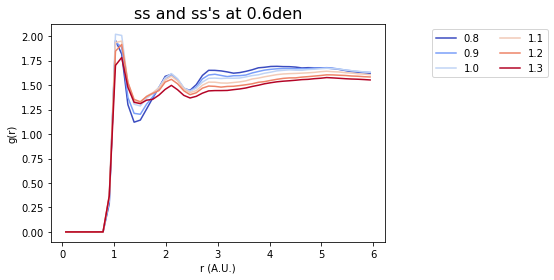

In [31]:
plot_txt(state_dict)